In [1]:
from typing import Optional, Iterable, Tuple
import requests
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import osmnx as ox
import rasterio
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import openeo

DATASET_DIR = Path("datasets")
DATASET_DIR.mkdir(parents=True, exist_ok=True)

BUILDING_DATASET_DIR = DATASET_DIR / "building_footprints"
BUILDING_DATASET_DIR.mkdir(parents=True, exist_ok=True)

SENTINEL_DATASET_DIR = DATASET_DIR / "sentinel"
SENTINEL_DATASET_DIR.mkdir(parents=True, exist_ok=True)

CITIES = ["Bologna, Italy", "Berlin, Germany", "Milan, Italy", "Odessa, Ukraine", "Washington, USA", "Manchester, UK", "Krasnodar, Russia", "Paris, France", "Barcelona, Spain", "Amsterdam, Netherlands"]

/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/osmnx/projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
def download_tile_with_progress(tile_id: str, output_file: Path, access_token: str):
    url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products({tile_id})/$value"
    
    s = requests.Session()
    s.headers.update({"Authorization": f"Bearer {access_token}"})
    
    response = s.head(url, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url = response.headers['Location']
        response = s.head(url, allow_redirects=False)
    
    chunk_size = 2**20  # mb
    with s.get(url, stream=True) as resp:
        with open(output_file, "wb") as f:
            print(f"Saving to {output_file}")
            for data in tqdm(
                resp.iter_content(chunk_size=chunk_size), 
                total=int(resp.headers.get("content-length", 0)) // chunk_size, 
                unit="MB",
                unit_scale=True,
                desc="Downloading...",
            ):
                f.write(data)

In [3]:
connection = openeo.connect("openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [4]:
def download_sentinel_openeo(connection, bbox, path):

    s2_cube = connection.load_collection(
        "SENTINEL2_L2A",
        temporal_extent=("2022-05-01", "2022-05-30"),
        spatial_extent={
            "west": bbox["west"],
            "south": bbox["south"],
            "east": bbox["east"],
            "north": bbox["north"]
        },
        bands=["B04", "B03", "B02", "B08"],
        max_cloud_cover=50,
    )
    
    R_band = s2_cube.band("B04")
    R_band.download(path / "R.tiff")
    G_band = s2_cube.band("B03")
    G_band.download(path / "G.tiff")
    B_band = s2_cube.band("B02")
    B_band.download(path / "B.tiff")
    IR_band = s2_cube.band("B08")
    IR_band.download(path / "IR.tiff")

In [5]:
def vis(img):
    masked_data = np.ma.masked_equal(img, 0)
    lq, uq = np.quantile(masked_data.compressed(), (0.01, 0.99))
    data = np.clip(img, a_min=lq, a_max=uq)
    data = (data - lq) / (uq - lq)
    if data.ndim == 2:
        plt.imshow(data, cmap="gray")
    elif data.ndim == 3:
        plt.imshow(data)
    return data

In [12]:
def build_bands(place):
    
    #Builings from OpenStreetMap
    buildings = ox.features_from_place(place, tags={'building':True})
    fig, ax = plt.subplots(figsize=(10, 10))
    buildings.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=0.5, alpha=0.2)
    plt.show()

    city_gdf = ox.geocode_to_gdf(place)
    city_gdf.envelope.explore()

    bbox = {
    "north": city_gdf.bbox_north[0],
    "south": city_gdf.bbox_south[0],
    "east": city_gdf.bbox_east[0],
    "west": city_gdf.bbox_west[0]
    }
    city_features = ox.features_from_bbox(north=bbox["north"], south=bbox["south"], east=bbox["east"], west=bbox["west"], tags={'building':True})

    download_sentinel_openeo(connection, bbox=bbox, path=SENTINEL_DATASET_DIR)

    with rasterio.open(SENTINEL_DATASET_DIR / "R.tiff") as f:
        r_data = np.transpose(f.read(), (1,2,0)).squeeze()
    with rasterio.open(SENTINEL_DATASET_DIR / "G.tiff") as f:
        g_data = np.transpose(f.read(), (1,2,0)).squeeze()    
    with rasterio.open(SENTINEL_DATASET_DIR / "B.tiff") as f:
        b_data = np.transpose(f.read(), (1,2,0)).squeeze()
    with rasterio.open(SENTINEL_DATASET_DIR / "IR.tiff") as f:
        ir_data = np.transpose(f.read(), (1,2,0)).squeeze()
    
    img = rasterio.open(SENTINEL_DATASET_DIR / "R.tiff")
    img_array = img.read().squeeze()

    #IRGB bands
    irgb_data = np.stack(
        [
        ir_data,
        r_data,
        g_data,
        b_data 
        ],
        axis=-1
    )
    irgb_img = vis(irgb_data)
    plt.show()

    #RGB bands
    rgb_data = np.stack(
        [
        r_data,
        g_data,
        b_data 
        ],
        axis=-1
    )
    rgb_img = vis(rgb_data)
    plt.show()

    #IRB bands
    irb_data = np.stack(
    [
       ir_data,
       r_data,
       b_data 
    ],
    axis=-1
    )
    irb_img = vis(irb_data)
    plt.show()

    #Single band
    r_img = vis(r_data)
    plt.show()

    #Overlapping builings
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(r_img, cmap="gray", extent=(buildings.total_bounds[0], buildings.total_bounds[2], buildings.total_bounds[1], buildings.total_bounds[3]))
    buildings.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=0.5, alpha=0.2)
    plt.show()

Bologna, Italy


/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid va

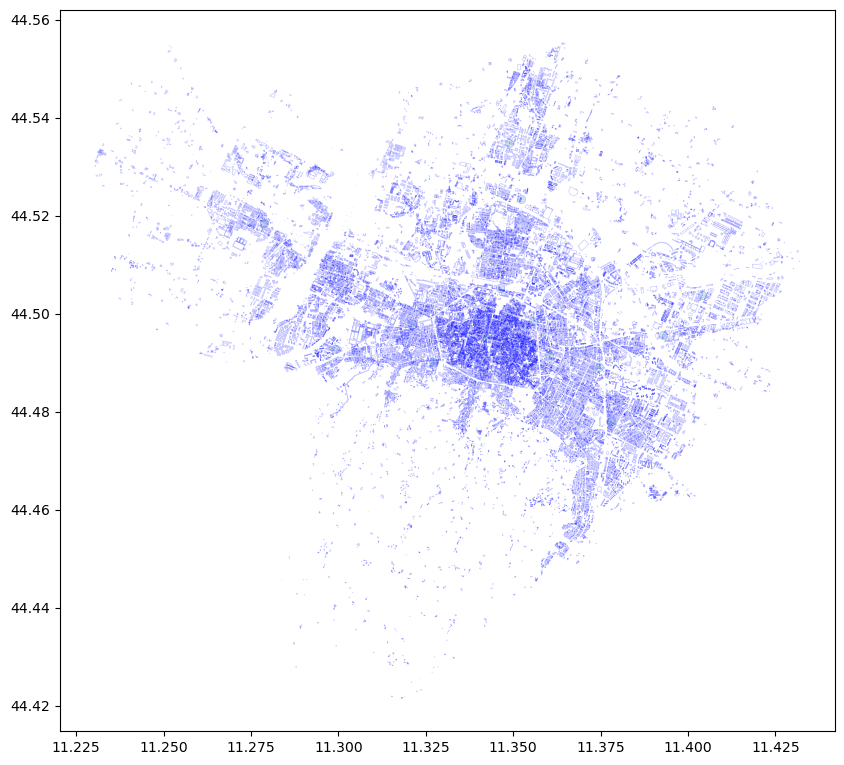

/var/folders/yn/hmxc2n8n47b0_cp42wr40nb40000gn/T/ipykernel_13433/421085314.py:18: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  city_features = ox.features_from_bbox(north=bbox["north"], south=bbox["south"], east=bbox["east"], west=bbox["west"], tags={'building':True})
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/opt/anaconda3/envs/sentsegm/lib/python3.9/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


KeyboardInterrupt: 

In [13]:
for city in CITIES:
    print(city)
    build_bands(city)